In [1]:
import pandas as pd

# Custom Libraries for saving excel and transformation of variables
import os
import sys
module_path = os.path.abspath(os.path.join('../../src/utils'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from custom_mmm_modelling import MMM_Modelling
from custom_modelling_plots import ModellingPlots
import pdb
import hyperopt
from hyperopt import fmin, tpe, atpe, hp, STATUS_OK, Trials
from functools import partial

In [2]:
pd.options.display.float_format = '{:20,.5f}'.format

pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199

In [3]:
media_dictionary = {'IMP' : 'Impression',
                    'SPEND' : 'Spend',
                    'VIEW_IMP' : 'Viewable Impression',
                    'CLK' : 'Click'}

In [4]:
# User Inputs
target_var = 'O_UNIT'

# standard names for folders are: new_customer_online, new_customer, sales_unit_online, sales_unit. 
# however the user can choose any folder name
# the folder would be created in models/manual_models
folder_name = 'sales_unit'

# standard names for folders are mix_media_metrics, impression, click, spend, viewable_impression
sub_folder = 'mix_media_metrics'

# input files
input_data_path = "../../data/processed_input_data/02_modelling_stack_data_seasonality.csv"

# Loading data dictionary
data_dict = pd.read_excel("../../data/input_data/WMG WAMM Project Data Dictionary_v12.xlsx")


In [5]:
# loading media hierarchy mapping
media_hier_click = pd.read_csv("../../data/input_data/media_hierarchy_CLK.csv")
media_hier_imp = pd.read_csv("../../data/input_data/media_hierarchy_IMP.csv")
media_hier_view_imp = pd.read_csv("../../data/input_data/media_hierarchy_VIEW_IMP.csv")
media_hier_spend = pd.read_csv("../../data/input_data/media_hierarchy_SPEND.csv")

media_hier = pd.concat([media_hier_click, media_hier_imp, media_hier_view_imp, media_hier_spend], axis= 0)


In [6]:
try:
    os.mkdir("../../models/{}/".format('manual'))
except:
    print("manual folder already exists")
    
folder_path = "../../models/manual/{}/".format(folder_name)
try:
    os.mkdir(folder_path)
except:
    print(folder_path + " folder already exists")
    
folder_path += sub_folder + "/"
try:
    os.mkdir(folder_path)
except:
    print(folder_path + " folder already exists")

manual folder already exists
../../models/manual/sales_unit/ folder already exists
../../models/manual/sales_unit/mix_media_metrics/ folder already exists


In [7]:
#loading data file
df = pd.read_csv(input_data_path, thousands= ",", na_values = " -   ")
df['index'] = pd.to_datetime(df['index']) # Formatting the date
df.set_index("index", inplace = True, drop= False)
df['M_SEARCH_MAN_CLK']=df['M_SBA_CLK']+df['M_SP_KWB_CLK']
df['M_SEARCH_AUTO_CLK']=df['M_SP_AB_CLK']

In [8]:
#Put dummy spends for national media to not break down in built in ROAS calculations
#df['M_NATIONAL_SEARCH_ECOMM_SPEND']=1000
df['M_NATIONAL_TV_SPEND']=1000 
df['M_SEARCH_MAN_SPEND']=df['M_SBA_SPEND']+df['M_SP_KWB_SPEND']
df['M_SEARCH_AUTO_SPEND']=df['M_SP_AB_SPEND']
#df['M_NATIONAL_AUDIO_SPEND']=1000
#df['M_NATIONAL_DISPLAY_ECOMM_SPEND']=1000
#df['M_NATIONAL_SEARCH_SPEND']=1000
#df['M_NATIONAL_DISPLAY_SPEND']=1000
#df['M_NATIONAL_VIDEO_SPEND']=1000

In [9]:
# Creating the modelling object
model_obj = MMM_Modelling(df.copy(), target_var, data_dict= data_dict,
                          output_path= folder_path, media_hier= media_hier,
                          comment= 'Media Mix Model')

/Users/m0u00pf/Documents/MMM/GSK Data Extraction/Brand 1 Sensodyne/Modeling without National Media/auto folder_structure/models/manual/sales_unit/mix_media_metrics/2021-07-30_model_outputs_v1/01_modelling_details.txt


In [10]:
# Creating train test split
model_obj.create_train_test_split('2019-01-01', '2021-03-31', '2021-04-01', '2021-04-30')

In [11]:
dummy_variables = ['D_HOL_CHRISTMAS','D_NATIONAL_WEATHER','D_HOL_THANKSGIVING','D_HOL_NEW_YEARS_DAY'
                          ,'D_HOL_EASTER',
                          'D_EVENT_COVID_LOCKDOWN','D_EVENT_PRE_SUPERBOWL',
                          'D_DAY_SUNDAY','D_EVENT_COVID_STOCKUP','D_EVENT_COVID_BURN',
                          #'PRICE',
                   'D_EVENT_EXTREME_COLD',
                   'INVENTORY_STORE_SELLABLE_ITEMS_COUNT','PRICE'
                   #,'Crest_O_PRICE','Colgate_O_PRICE'
                   #,'O_CAT_ORAL CARE_O_UNIT'
                   #,'Colgate_MEDIA_SPEND','Crest_MEDIA_SPEND'#,'INVENTORY_OOS_RATE_STORE'
                   #,'C_COLGATE_PRICE_IND'
                  ]

In [30]:
#Define params space
fspace = {
    'M_ON_DIS_AT_IMP_LAG': hp.quniform('M_ON_DIS_AT_IMP_LAG', 0, 14, 1),
    'M_ON_DIS_CT_ROS_IMP_LAG': hp.quniform('M_ON_DIS_CT_ROS_IMP_LAG', 0, 14, 1),
    'M_ON_DIS_HPLO_IMP_LAG': hp.quniform('M_ON_DIS_HPLO_IMP_LAG', 0, 14, 1),
    'M_ON_DIS_KW_IMP_LAG': hp.quniform('M_ON_DIS_KW_IMP_LAG', 0, 14, 1),
    'M_OFF_DIS_WN_IMP_LAG': hp.quniform('M_OFF_DIS_WN_IMP_LAG', 0, 14, 1), 
    'M_OFF_DIS_SMEDIA_IMP_LAG': hp.quniform('M_OFF_DIS_SMEDIA_IMP_LAG', 0, 14, 1), 
    'M_NATIONAL_TV_IMP_LAG': hp.quniform('M_NATIONAL_TV_IMP_LAG', 7, 14, 1), 
    #'M_NATIONAL_AUDIO_IMP_LAG': hp.randint('M_NATIONAL_AUDIO_IMP_LAG', 14), 
    #'M_NATIONAL_DISPLAY_IMP_LAG': hp.randint('M_NATIONAL_DISPLAY_IMP_LAG', 14), 
    #'M_NATIONAL_DISPLAY_ECOMM_IMP_LAG': hp.randint('M_NATIONAL_DISPLAY_ECOMM_IMP_LAG', 14), 
    #'M_NATIONAL_VIDEO_IMP_LAG': hp.randint('M_NATIONAL_VIDEO_IMP_LAG', 14), 
    #'M_SP_AB_CLK_LAG': hp.randint('M_SP_AB_CLK_LAG', 4),
    #'M_SP_KWB_CLK_LAG': hp.randint('M_SP_KWB_CLK_LAG', 4),
    #'M_SBA_CLK_LAG': hp.randint('M_SBA_CLK_LAG', 4),
    'M_SEARCH_AUTO_CLK_LAG': hp.quniform('M_SEARCH_AUTO_CLK_LAG',0,  4, 1),
    'M_SEARCH_MAN_CLK_LAG': hp.quniform('M_SEARCH_MAN_CLK_LAG', 0, 4, 1),
    #'M_NATIONAL_SEARCH_CLK_LAG': hp.randint('M_NATIONAL_SEARCH_CLK_LAG', 4),
    #'M_NATIONAL_SEARCH_ECOMM_CLK_LAG': hp.randint('M_NATIONAL_SEARCH_ECOMM_CLK_LAG', 4),
   
    'M_ON_DIS_AT_IMP_HALF': hp.quniform('M_ON_DIS_AT_IMP_HALF', 0, 8, 1),
    'M_ON_DIS_CT_ROS_IMP_HALF': hp.quniform('M_ON_DIS_CT_ROS_IMP_HALF', 0, 8, 1),
    'M_ON_DIS_HPLO_IMP_HALF': hp.quniform('M_ON_DIS_HPLO_IMP_HALF', 0, 8, 1),
    'M_ON_DIS_KW_IMP_HALF': hp.quniform('M_ON_DIS_KW_IMP_HALF', 0, 8, 1),
    'M_OFF_DIS_WN_IMP_HALF': hp.quniform('M_OFF_DIS_WN_IMP_HALF', 0, 8, 1), 
    'M_OFF_DIS_SMEDIA_IMP_HALF': hp.quniform('M_OFF_DIS_SMEDIA_IMP_HALF', 0, 8, 1), 
    'M_NATIONAL_TV_IMP_HALF': hp.quniform('M_NATIONAL_TV_IMP_HALF', 2, 8, 1), 
    #'M_NATIONAL_AUDIO_IMP_HALF': hp.randint('M_NATIONAL_AUDIO_IMP_HALF', 8), 
    #'M_NATIONAL_DISPLAY_IMP_HALF': hp.randint('M_NATIONAL_DISPLAY_IMP_HALF', 8), 
    #'M_NATIONAL_DISPLAY_ECOMM_IMP_HALF': hp.randint('M_NATIONAL_DISPLAY_ECOMM_IMP_HALF', 8), 
    #'M_NATIONAL_VIDEO_IMP_HALF': hp.randint('M_NATIONAL_VIDEO_IMP_HALF', 8), 
    #'M_SP_AB_CLK_HALF': hp.randint('M_SP_AB_CLK_HALF', 4),
    #'M_SP_KWB_CLK_HALF': hp.randint('M_SP_KWB_CLK_HALF', 4),
    #'M_SBA_CLK_HALF': hp.randint('M_SBA_CLK_HALF', 4),
    'M_SEARCH_AUTO_CLK_HALF': hp.quniform('M_SEARCH_AUTO_CLK_HALF', 0, 4, 1),
    'M_SEARCH_MAN_CLK_HALF': hp.quniform('M_SEARCH_MAN_CLK_HALF', 0, 4, 1),
    #'M_NATIONAL_SEARCH_CLK_HALF': hp.randint('M_NATIONAL_SEARCH_CLK_HALF', 4),
    #'M_NATIONAL_SEARCH_ECOMM_CLK_HALF': hp.randint('M_NATIONAL_SEARCH_ECOMM_CLK_HALF', 4),
  
    'M_ON_DIS_AT_IMP_INFLE': hp.quniform('M_ON_DIS_AT_IMP_INFLE', 1, 8, 1),
    'M_ON_DIS_CT_ROS_IMP_INFLE': hp.quniform('M_ON_DIS_CT_ROS_IMP_INFLE', 1, 8, 1),
    'M_ON_DIS_HPLO_IMP_INFLE': hp.quniform('M_ON_DIS_HPLO_IMP_INFLE', 1, 8, 1),
    'M_ON_DIS_KW_IMP_INFLE': hp.quniform('M_ON_DIS_KW_IMP_INFLE', 1, 6, 1),
    'M_OFF_DIS_WN_IMP_INFLE': hp.quniform('M_OFF_DIS_WN_IMP_INFLE', 1, 6, 1), 
    'M_OFF_DIS_SMEDIA_IMP_INFLE': hp.quniform('M_OFF_DIS_SMEDIA_IMP_INFLE', 1, 6, 1), 
    'M_NATIONAL_TV_IMP_INFLE': hp.quniform('M_NATIONAL_TV_IMP_INFLE', 1, 8, 1), 
    #'M_NATIONAL_AUDIO_IMP_INFLE': hp.randint('M_NATIONAL_AUDIO_IMP_INFLE', 10), 
    #'M_NATIONAL_DISPLAY_IMP_INFLE': hp.randint('M_NATIONAL_DISPLAY_IMP_INFLE', 10), 
    #'M_NATIONAL_DISPLAY_ECOMM_IMP_INFLE': hp.randint('M_NATIONAL_DISPLAY_ECOMM_IMP_INFLE', 10), 
    #'M_NATIONAL_VIDEO_IMP_INFLE': hp.randint('M_NATIONAL_VIDEO_IMP_INFLE', 10), 
    #'M_SP_AB_CLK_INFLE': hp.randint('M_SP_AB_CLK_INFLE', 4),
    #'M_SP_KWB_CLK_INFLE': hp.randint('M_SP_KWB_CLK_INFLE', 4),
    #'M_SBA_CLK_INFLE': hp.randint('M_SBA_CLK_INFLE', 4),
    'M_SEARCH_AUTO_CLK_INFLE': hp.quniform('M_SEARCH_AUTO_CLK_INFLE', 1, 4, 1),
    'M_SEARCH_MAN_CLK_INFLE': hp.quniform('M_SEARCH_MAN_CLK_INFLE', 1, 4, 1),
    #'M_NATIONAL_SEARCH_CLK_INFLE': hp.randint('M_NATIONAL_SEARCH_CLK_INFLE', 4),
    #'M_NATIONAL_SEARCH_ECOMM_CLK_INFLE': hp.randint('M_NATIONAL_SEARCH_ECOMM_CLK_INFLE', 4),
  
    'M_ON_DIS_AT_IMP_SCALE': hp.quniform('M_ON_DIS_AT_IMP_SCALE', 1, 12, 1),
    'M_ON_DIS_CT_ROS_IMP_SCALE': hp.quniform('M_ON_DIS_CT_ROS_IMP_SCALE', 1, 12, 1),
    'M_ON_DIS_HPLO_IMP_SCALE': hp.quniform('M_ON_DIS_HPLO_IMP_SCALE', 1, 12, 1),
    'M_ON_DIS_KW_IMP_SCALE': hp.quniform('M_ON_DIS_KW_IMP_SCALE', 1, 9, 1),
    'M_OFF_DIS_WN_IMP_SCALE': hp.quniform('M_OFF_DIS_WN_IMP_SCALE', 1, 8, 1),
    'M_OFF_DIS_SMEDIA_IMP_SCALE': hp.quniform('M_OFF_DIS_SMEDIA_IMP_SCALE', 1, 8, 1), 
    'M_NATIONAL_TV_IMP_SCALE': hp.quniform('M_NATIONAL_TV_IMP_SCALE', 1, 12, 1), 
    #'M_NATIONAL_AUDIO_IMP_SCALE': hp.randint('M_NATIONAL_AUDIO_IMP_SCALE', 12), 
    #'M_NATIONAL_DISPLAY_IMP_SCALE': hp.randint('M_NATIONAL_DISPLAY_IMP_SCALE', 12), 
    #'M_NATIONAL_DISPLAY_ECOMM_IMP_SCALE': hp.randint('M_NATIONAL_DISPLAY_ECOMM_IMP_SCALE', 12), 
    #'M_NATIONAL_VIDEO_IMP_SCALE': hp.randint('M_NATIONAL_VIDEO_IMP_SCALE', 12), 
    #'M_SP_AB_CLK_SCALE': hp.randint('M_SP_AB_CLK_SCALE', 6),
    #'M_SP_KWB_CLK_SCALE': hp.randint('M_SP_KWB_CLK_SCALE', 6),
    #'M_SBA_CLK_SCALE': hp.randint('M_SBA_CLK_SCALE', 6),
    'M_SEARCH_AUTO_CLK_SCALE': hp.quniform('M_SEARCH_AUTO_CLK_SCALE', 1, 5, 1),
    'M_SEARCH_MAN_CLK_SCALE': hp.quniform('M_SEARCH_MAN_CLK_SCALE', 1, 5, 1),
    #'M_NATIONAL_SEARCH_CLK_SCALE': hp.randint('M_NATIONAL_SEARCH_CLK_SCALE', 6),
    #'M_NATIONAL_SEARCH_ECOMM_CLK_SCALE': hp.randint('M_NATIONAL_SEARCH_ECOMM_CLK_SCALE', 6)
}

In [12]:
#define media list
media_list = ['M_ON_DIS_AT_IMP','M_ON_DIS_CT_ROS_IMP','M_ON_DIS_HPLO_IMP','M_ON_DIS_KW_IMP','M_OFF_DIS_WN_IMP', 'M_OFF_DIS_SMEDIA_IMP', 'M_NATIONAL_TV_IMP'#, 'M_NATIONAL_AUDIO_IMP','M_NATIONAL_DISPLAY_IMP','M_NATIONAL_DISPLAY_ECOMM_IMP','M_NATIONAL_VIDEO_IMP', 
              #,'M_SP_AB_CLK'
              ,'M_SEARCH_AUTO_CLK','M_SEARCH_MAN_CLK'#'M_SP_KWB_CLK','M_SBA_CLK'#,'M_NATIONAL_SEARCH_CLK','M_NATIONAL_SEARCH_ECOMM_CLK'
             ]
coeff_summary = pd.DataFrame()

In [27]:
#function to evaluate each trial
def f(params):
    media_variables=[]
    for i in media_list:
        var = i+'_LAG'
        lag = params[var]
        var = i+'_HALF'
        half = params[var]
        var = i+'_INFLE'
        infle = params[var]
        var = i+'_SCALE'
        scale  = params[var]
        final_var = i+'_'+str(lag)+'_'+str(half)+'_'+str(infle)+'_'+str(scale)+'_0'
        media_variables.append(final_var)
    

    other_variables = ['O_UNIT_SEASONALITY','O_UNIT_RESIDUAL']

    # Selecting all the independent variables
    all_independent_variables = dummy_variables + media_variables + other_variables
    model_obj.create_missing_media_transformations(media_variables, 
                                                   trans_start_date= '2019-01-01', trans_end_date= '2020-12-31',reset=True)

    model_obj.create_model_results(X_vars= all_independent_variables, model_type= 'Manual Model 1')


    coeff_summary = model_obj.model_dump['Manual Model 1']['Coefficient Summary'].copy()
    ddf = coeff_summary[coeff_summary['Variables'].str.contains("M_")]
    ddf['p-value'].sum()

    #obj  = -ddf['Coefficient']
    #val  = obj.sum() + ddf['p-value'].sum()

    #set up coefficients. penalize negative coefs and large p values
    neg_coefs = sum(ddf['Coefficient']<0) #ddf[ddf['Coefficient']<0]['Coefficient'].sum()
    pos_coef = ddf[ddf['Coefficient']>=0]['Coefficient'].sum()
    large_p = ddf['p-value'].sum()
    #small_p = 1.0/(ddf[(ddf['Coefficient']<0)&(ddf['p-value']<=0.25)]['p-value'].sum())

    obj = neg_coefs*10000 #- pos_coef*100

    val  = obj + large_p*10 #+ small_p*100
    return {'loss': val, 'status': STATUS_OK}


In [28]:
#add best iteration from previous set
points_to_evaluate=[{
'M_NATIONAL_TV_IMP_HALF': 8.0,
 'M_NATIONAL_TV_IMP_INFLE': 1.0,
 'M_NATIONAL_TV_IMP_LAG': 7.0,
 'M_NATIONAL_TV_IMP_SCALE': 12.0,
 'M_OFF_DIS_SMEDIA_IMP_HALF': 8.0,
 'M_OFF_DIS_SMEDIA_IMP_INFLE': 5.0,
 'M_OFF_DIS_SMEDIA_IMP_LAG': 7.0,
 'M_OFF_DIS_SMEDIA_IMP_SCALE': 6.0,
 'M_OFF_DIS_WN_IMP_HALF': 6.0,
 'M_OFF_DIS_WN_IMP_INFLE': 6.0,
 'M_OFF_DIS_WN_IMP_LAG': 5.0,
 'M_OFF_DIS_WN_IMP_SCALE': 7.0,
 'M_ON_DIS_AT_IMP_HALF': 8.0,
 'M_ON_DIS_AT_IMP_INFLE': 2.0,
 'M_ON_DIS_AT_IMP_LAG': 14.0,
 'M_ON_DIS_AT_IMP_SCALE': 6.0,
 'M_ON_DIS_CT_ROS_IMP_HALF': 3.0,
 'M_ON_DIS_CT_ROS_IMP_INFLE': 3.0,
 'M_ON_DIS_CT_ROS_IMP_LAG': 6.0,
 'M_ON_DIS_CT_ROS_IMP_SCALE': 10.0,
 'M_ON_DIS_HPLO_IMP_HALF': 0.0,
 'M_ON_DIS_HPLO_IMP_INFLE': 1.0,
 'M_ON_DIS_HPLO_IMP_LAG': 6.0,
 'M_ON_DIS_HPLO_IMP_SCALE': 2.0,
 'M_ON_DIS_KW_IMP_HALF': 0.0,
 'M_ON_DIS_KW_IMP_INFLE': 6.0,
 'M_ON_DIS_KW_IMP_LAG': 5.0,
 'M_ON_DIS_KW_IMP_SCALE': 3.0,
 'M_SEARCH_AUTO_CLK_HALF': 4.0,
 'M_SEARCH_AUTO_CLK_INFLE': 4.0,
 'M_SEARCH_AUTO_CLK_LAG': 1.0,
 'M_SEARCH_AUTO_CLK_SCALE': 5.0,
 'M_SEARCH_MAN_CLK_HALF': 1.0,
 'M_SEARCH_MAN_CLK_INFLE': 4.0,
 'M_SEARCH_MAN_CLK_LAG': 2.0,
 'M_SEARCH_MAN_CLK_SCALE': 4.0
}]

In [31]:
best = fmin(fn=f, space=fspace, algo=atpe.suggest, max_evals=4000, verbose=True, points_to_evaluate=points_to_evaluate, trials_save_file="hyperopt_units_merged_ctalt2s5_offsplit_output.pkl")
print('best:', best)

4001trial [2:56:26,  2.65s/trial, best loss: 7.84]                                   
best: {'M_NATIONAL_TV_IMP_HALF': 8.0, 'M_NATIONAL_TV_IMP_INFLE': 1.0, 'M_NATIONAL_TV_IMP_LAG': 7.0, 'M_NATIONAL_TV_IMP_SCALE': 12.0, 'M_OFF_DIS_SMEDIA_IMP_HALF': 8.0, 'M_OFF_DIS_SMEDIA_IMP_INFLE': 5.0, 'M_OFF_DIS_SMEDIA_IMP_LAG': 7.0, 'M_OFF_DIS_SMEDIA_IMP_SCALE': 8.0, 'M_OFF_DIS_WN_IMP_HALF': 6.0, 'M_OFF_DIS_WN_IMP_INFLE': 6.0, 'M_OFF_DIS_WN_IMP_LAG': 5.0, 'M_OFF_DIS_WN_IMP_SCALE': 8.0, 'M_ON_DIS_AT_IMP_HALF': 8.0, 'M_ON_DIS_AT_IMP_INFLE': 2.0, 'M_ON_DIS_AT_IMP_LAG': 14.0, 'M_ON_DIS_AT_IMP_SCALE': 6.0, 'M_ON_DIS_CT_ROS_IMP_HALF': 3.0, 'M_ON_DIS_CT_ROS_IMP_INFLE': 3.0, 'M_ON_DIS_CT_ROS_IMP_LAG': 6.0, 'M_ON_DIS_CT_ROS_IMP_SCALE': 10.0, 'M_ON_DIS_HPLO_IMP_HALF': 0.0, 'M_ON_DIS_HPLO_IMP_INFLE': 1.0, 'M_ON_DIS_HPLO_IMP_LAG': 6.0, 'M_ON_DIS_HPLO_IMP_SCALE': 1.0, 'M_ON_DIS_KW_IMP_HALF': 0.0, 'M_ON_DIS_KW_IMP_INFLE': 6.0, 'M_ON_DIS_KW_IMP_LAG': 5.0, 'M_ON_DIS_KW_IMP_SCALE': 4.0, 'M_SEARCH_AUTO_CLK_HALF': 4.0

## Explore the model trials save object, save top trials into a Pandas DataFrame

In [32]:
import pickle
with open("hyperopt_units_merged_ctalt2s5_offsplit_output.pkl","rb") as trialsfile:
    trials_summary=pickle.load(trialsfile)

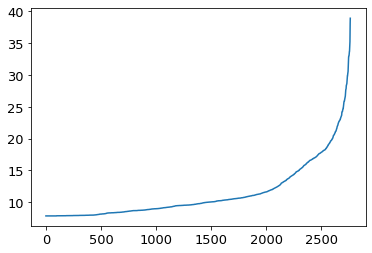

In [43]:
#Plot objective function values from lowest to highest
from matplotlib import pyplot as plt
plt.plot(sorted([trial['result']['loss'] for trial in trials_summary._trials])[0:2763]) 
#can play with the range above to find a good cutoff

In [44]:
top_n=2763 #your choice
trials_summary_cutoff=sorted([trial['result']['loss'] for trial in trials_summary._trials])[top_n-1]
#get top n objective function values and parameters
trials_summary=[{**{'objective':trial['result']['loss']},
 **{var:val[0] for var,val in trial['misc']['vals'].items()}} 
                            for trial in trials_summary._trials 
                             if trial['result']['loss']<=trials_summary_cutoff]
trials_summary=sorted(trials_summary, key = lambda i: i['objective'])

In [45]:
dummy_variables = ['D_HOL_CHRISTMAS','D_NATIONAL_WEATHER','D_HOL_THANKSGIVING','D_HOL_NEW_YEARS_DAY'
                          ,'D_HOL_EASTER',
                          'D_EVENT_COVID_LOCKDOWN','D_EVENT_PRE_SUPERBOWL',
                          'D_DAY_SUNDAY','D_EVENT_COVID_STOCKUP','D_EVENT_COVID_BURN',
                          #'PRICE',
                   'D_EVENT_EXTREME_COLD',
                   'INVENTORY_STORE_SELLABLE_ITEMS_COUNT','PRICE'
                   #,'Crest_O_PRICE','Colgate_O_PRICE'
                   #,'O_CAT_ORAL CARE_O_UNIT'
                   #,'Colgate_MEDIA_SPEND','Crest_MEDIA_SPEND'#,'INVENTORY_OOS_RATE_STORE'
                   #,'C_COLGATE_PRICE_IND'
                  ]



In [46]:
#Save all candidate model results in model_obj.model_dump: 1 is already the best.
for ix in range(len(trials_summary)):
    print(ix)
    row=trials_summary[ix]
    media_variables=[]
    for i in media_list:
        var = i+'_LAG'
        lag = row[var]
        var = i+'_HALF'
        half = row[var]
        var = i+'_INFLE'
        infle = row[var]
        var = i+'_SCALE'
        scale  = row[var]
        final_var = i+'_'+str(lag)+'_'+str(half)+'_'+str(infle)+'_'+str(scale)+'_0'
        media_variables.append(final_var)
    other_variables = ['O_UNIT_SEASONALITY','O_UNIT_RESIDUAL']
    # Selecting all the independent variables
    #use media_variables in the modeling notebook
    all_independent_variables = dummy_variables + media_variables + other_variables
    model_obj.create_missing_media_transformations(media_variables, 
                                               trans_start_date= '2019-01-01', trans_end_date= '2020-12-31',reset=True)
    model_obj.create_model_results(X_vars= all_independent_variables, model_type= 'Manual Model '+str(ix+1))
    #Populate coefficients, Annual Contribution and Spend for each media and
    #output into a model selection table
    media_media_final={media:final_var for media,final_var in zip(media_list,media_variables)}
    coef_summary=model_obj.model_dump['Manual Model '+str(ix+1)]['Coefficient Summary']
    contrib_summary=model_obj.model_dump['Manual Model '+str(ix+1)]['ROAS Yearly']
    model_stats_summary=model_obj.model_dump['Manual Model '+str(ix+1)]['Modelling Metrics'].iloc[0:2,]
    #Model performance metrics
    row['MAPE_FIT']=model_stats_summary.iloc[0,0]
    row['MAPE_VALID']=model_stats_summary.iloc[0,1]
    row['RSQ_FIT']=model_stats_summary.iloc[1,0]
    row['RSQ_VALID']=model_stats_summary.iloc[1,1]
    #Non-media coefficients
    nonmedia=[var for var in list(set(coef_summary['Variables'].values.tolist())) if "M_" not in var]  
    for source in nonmedia:
        row[source+'_COEF']=coef_summary[coef_summary['Variables']==source]['Coefficient'].values[0] 
    #Media coefficients
    for media in media_media_final.keys():
        row[media+'_COEF']=coef_summary[coef_summary['Variables']==media_media_final[media]]['Coefficient'].values[0]
        row[media+'_COEFSTD']=coef_summary[coef_summary['Variables']==media_media_final[media]]['Standardized Coefficient'].values[0]
        row[media+'_PVAL']=coef_summary[coef_summary['Variables']==media_media_final[media]]['p-value'].values[0]
        row[media+'_EL']=coef_summary[coef_summary['Variables']==media_media_final[media]]['Elasticity'].values[0]
        row[media+'_RELIMP']=coef_summary[coef_summary['Variables']==media_media_final[media]]['Relative Importance'].values[0]
        row[media+'_VIF']=coef_summary[coef_summary['Variables']==media_media_final[media]]['VIF'].values[0]
        #Media activity by year
        for year in list(set(contrib_summary['Year'].values.tolist())):
            row[media+'_CONTRIB_'+str(year)]=contrib_summary[(contrib_summary['Variable']==media_media_final[media])&(contrib_summary['Year']==year)]['Contribution'].values[0]
            row[media+'_SPEND_'+str(year)]=contrib_summary[(contrib_summary['Variable']==media_media_final[media])&(contrib_summary['Year']==year)]['Spend ($)'].values[0]
            row[media+'_TOTAL_'+str(year)]=model_obj.df[media].groupby(model_obj.df[media].index.year).agg(sum)[year]
            row[media+'_IROAS_'+str(year)]=row[media+'_CONTRIB_'+str(year)]/row[media+'_SPEND_'+str(year)]
trials_summary_out=pd.DataFrame(trials_summary)
trials_summary_out.to_excel(model_obj.output_path+'/Hyperopt_Trials_Units_Ctalt2s3_Top'+str(top_n)+'.xlsx')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


In [18]:
trials_summary[0]

{'objective': 7.919999999999999,
 'M_NATIONAL_TV_IMP_HALF': 8.0,
 'M_NATIONAL_TV_IMP_INFLE': 1.0,
 'M_NATIONAL_TV_IMP_LAG': 7.0,
 'M_NATIONAL_TV_IMP_SCALE': 12.0,
 'M_OFF_DIS_SMEDIA_IMP_HALF': 8.0,
 'M_OFF_DIS_SMEDIA_IMP_INFLE': 5.0,
 'M_OFF_DIS_SMEDIA_IMP_LAG': 7.0,
 'M_OFF_DIS_SMEDIA_IMP_SCALE': 6.0,
 'M_OFF_DIS_WN_IMP_HALF': 6.0,
 'M_OFF_DIS_WN_IMP_INFLE': 6.0,
 'M_OFF_DIS_WN_IMP_LAG': 5.0,
 'M_OFF_DIS_WN_IMP_SCALE': 7.0,
 'M_ON_DIS_AT_IMP_HALF': 8.0,
 'M_ON_DIS_AT_IMP_INFLE': 2.0,
 'M_ON_DIS_AT_IMP_LAG': 14.0,
 'M_ON_DIS_AT_IMP_SCALE': 6.0,
 'M_ON_DIS_CT_ROS_IMP_HALF': 3.0,
 'M_ON_DIS_CT_ROS_IMP_INFLE': 3.0,
 'M_ON_DIS_CT_ROS_IMP_LAG': 6.0,
 'M_ON_DIS_CT_ROS_IMP_SCALE': 10.0,
 'M_ON_DIS_HPLO_IMP_HALF': 0.0,
 'M_ON_DIS_HPLO_IMP_INFLE': 1.0,
 'M_ON_DIS_HPLO_IMP_LAG': 6.0,
 'M_ON_DIS_HPLO_IMP_SCALE': 2.0,
 'M_ON_DIS_KW_IMP_HALF': 0.0,
 'M_ON_DIS_KW_IMP_INFLE': 6.0,
 'M_ON_DIS_KW_IMP_LAG': 5.0,
 'M_ON_DIS_KW_IMP_SCALE': 3.0,
 'M_SEARCH_AUTO_CLK_HALF': 4.0,
 'M_SEARCH_AUTO_CLK_INFLE': 4

In [62]:
#"Best" Model

#media_variables=[]
#for i in media_list:
#    var = i+'_LAG'
#    lag = best[var]
#    var = i+'_HALF'
#    half = best[var]
#    var = i+'_INFLE'
#    infle = best[var]
#    var = i+'_SCALE'
#    scale  = best[var]
#    final_var = i+'_'+str(lag)+'_'+str(half)+'_'+str(infle)+'_'+str(scale)+'_0'
#    media_variables.append(final_var)

#other_variables = ['O_NEW_CUSTOMER_SARIMAX (1, 1, 2) (2, 0, 1, 7)']

# Selecting all the independent variables
#use media_variables in the modeling notebook
#all_independent_variables = dummy_variables + media_variables + other_variables
#model_obj.create_missing_media_transformations(media_variables, 
#                                               trans_start_date= '2019-01-01', trans_end_date= '2020-12-31')
#model_obj.create_model_results(X_vars= all_independent_variables, model_type= 'Manual Model 1')

#Print best performing model attributes
print(model_obj.model_dump['Manual Model 1610']['Coefficient Summary'])

coeff_summary = model_obj.model_dump['Manual Model 1610']['Coefficient Summary'].copy()
ddf = coeff_summary[coeff_summary['Variables'].str.contains("M_")]
ddf['p-value'].sum()

#set up coefficients. penalize negative coefs and large p values
neg_coefs = sum(ddf['Coefficient']<0) #ddf[ddf['Coefficient']<0]['Coefficient'].sum()
pos_coef = ddf[ddf['Coefficient']>=0]['Coefficient'].sum()
large_p = ddf['p-value'].sum()
#small_p = 1.0/(ddf[(ddf['Coefficient']<0)&(ddf['p-value']<=0.25)]['p-value'].sum())

obj = neg_coefs*10000 #- pos_coef*100

val  = obj + large_p*10 #+ small_p*100
print(val)

                                 Variables          Coefficient  \
0   INTERCEPT_TERM                                142,276.75696   
1   D_HOL_CHRISTMAS                                -3,822.16702   
2   D_NATIONAL_WEATHER                                122.90013   
3   D_HOL_THANKSGIVING                            -11,157.97134   
4   D_HOL_NEW_YEARS_DAY                            -3,442.70913   
5   D_HOL_EASTER                                   -9,006.74566   
6   D_EVENT_COVID_LOCKDOWN                         30,240.52424   
7   D_EVENT_PRE_SUPERBOWL                           3,994.74241   
8   D_DAY_SUNDAY                                      886.83650   
9   D_EVENT_COVID_STOCKUP                          36,085.50607   
10  D_EVENT_COVID_BURN                             -7,384.24519   
11  D_EVENT_EXTREME_COLD                          -11,277.80952   
12  INVENTORY_STORE_SELLABLE_ITEMS_COUNT              722.97279   
13  PRICE                                         -12,565.6750

Variables          Coefficient  \
0   INTERCEPT_TERM                                142,276.75696   
1   D_HOL_CHRISTMAS                                -3,822.16702   
2   D_NATIONAL_WEATHER                                122.90013   
3   D_HOL_THANKSGIVING                            -11,157.97134   
4   D_HOL_NEW_YEARS_DAY                            -3,442.70913   
5   D_HOL_EASTER                                   -9,006.74566   
6   D_EVENT_COVID_LOCKDOWN                         30,240.52424   
7   D_EVENT_PRE_SUPERBOWL                           3,994.74241   
8   D_DAY_SUNDAY                                      886.83650   
9   D_EVENT_COVID_STOCKUP                          36,085.50607   
10  D_EVENT_COVID_BURN                             -7,384.24519   
11  D_EVENT_EXTREME_COLD                          -11,277.80952   
12  INVENTORY_STORE_SELLABLE_ITEMS_COUNT              722.97279   
13  PRICE                                         -12,565.67502   
14  M_ON_DIS_AT_IMP_14.0_8.0_2.0_6.0_0                  0.00283   
15  M_ON_DIS_CT_ROS_IMP_6.0_3.0_3.0_12.0_0              0.00098   
16  M_ON_DIS_HPLO_IMP_6.0_0.0_1.0_1.0_0                 0.00117   
17  M_ON_DIS_KW_IMP_5.0_0.0_6.0_4.0_0                   0.00646   
18  M_OFF_DIS_WN_IMP_5.0_6.0_5.0_7.0_0                  0.00011   
19  M_OFF_DIS_SMEDIA_IMP_7.0_8.0_5.0_8.0_0              0.00463   
20  M_NATIONAL_TV_IMP_7.0_8.0_1.0_12.0_0               28.10899   
21  M_SEARCH_AUTO_CLK_1.0_4.0_4.0_5.0_0                 0.06447   
22  M_SEARCH_MAN_CLK_2.0_1.0_4.0_4.0_0                  0.43020   
23  O_UNIT_SEASONALITY                                  1.00291   
24  O_UNIT_RESIDUAL                                     0.88206   

             Elasticity    Custom Elasticity  Incremental Impact  
0               0.00000              0.00000  0                   
1              -0.00010              0.00000  0                   
2               0.00417              0.00000  0                   
3              -0.00029              0.00000  0                   
4              -0.00014              0.00000  0                   
5              -0.00035              0.00000  0                   
6               0.00040              0.00000  0                   
7               0.00016              0.00000  0                   
8               0.00141              0.00000  0                   
9               0.00993              0.00000  0                   
10             -0.00271              0.00000  0                   
11             -0.00044              0.00000  0                   
12              0.23738              0.00000  0                   
13             -0.86498              0.00000  0                   
14              0.00843              0.00492  649416              
15              0.00074              0.00093  55394               
16              0.00163              0.00239  120985              
17              0.00039              0.00502  29603               
18              0.00010              0.00008  8849                
19              0.00146              0.00446  111891              
20              0.01526             28.98175  1164755             
21              0.00043              0.05007  32970               
22              0.00104              0.39690  79568               
23             -0.00030              0.00000  0                   
24              0.00002              0.00000  0

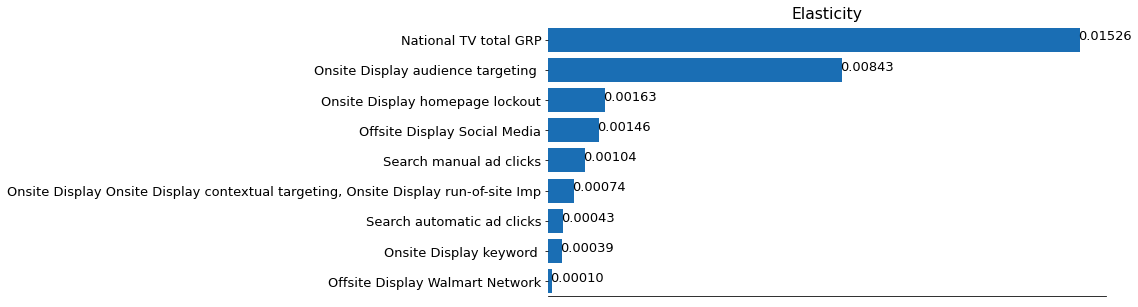

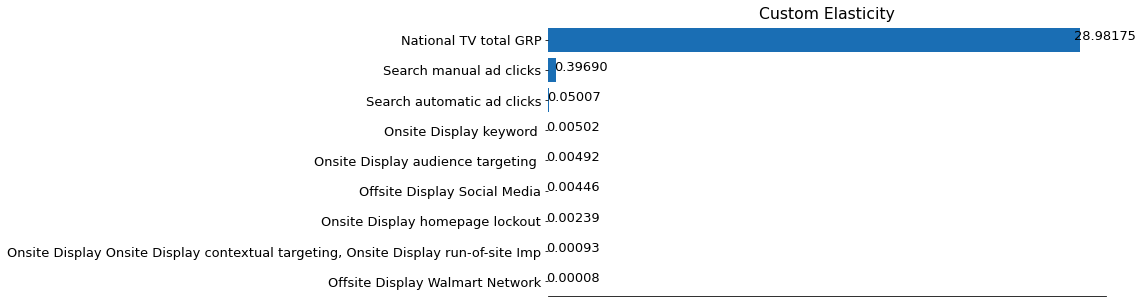

In [63]:
model_obj.data_dict=data_dict
all_vars = list(model_obj.model_dump['Manual Model 1610']['Coefficient Summary'].Variables).copy()
media_vars = [col for col in all_vars if col.startswith('M_')]
model_obj.create_missing_media_transformations(media_vars, 
                                               trans_start_date= '2019-01-01', trans_end_date= '2020-12-31')
all_indep_vars=[var for var in all_vars if var!='INTERCEPT_TERM']
model_obj.create_model_results(X_vars= all_indep_vars, model_type= 'Manual Model 1610')
model_obj.visualize_model_custom_period(all_indep_vars, 
                                       start_date= '2019-01-01', end_date= '2021-04-30')

In [64]:
# Import the necessaries libraries
import plotly.offline as pyo
import plotly.graph_objs as go
# Set notebook mode to work in offline
pyo.init_notebook_mode()

In [65]:
model_obj.visualize_model_outputs('Manual Model 1610', contribution_graph= True, add_residual= True, separate_validation= True,
                                  analyst_review= True, show_yaxis= True,
                                  )

Display Level  \
0   National TV total GRP                                                                
1   Offsite Display Social Media                                                         
2   Onsite Display audience targeting                                                    
3   Onsite Display homepage lockout                                                      
4   Onsite Display keyword                                                               
5   Search manual ad clicks                                                              
6   Onsite Display Onsite Display contextual targeting, Onsite Display run-of-site Imp   
7   Search automatic ad clicks                                                           
8   Offsite Display Walmart Network                                                      
9   Total Incremental                                                                    
10  Base                                                                                 
11  Total                                                                                

    Contribution Share (%) Total Contribution Total Sales ($) Total Spend ($)  \
0  51.7                     1,164,755          7,175,774       851,000          
1  5.0                      111,891            689,333         157,539          
2  28.8                     649,416            4,000,898       1,534,639        
3  5.4                      120,985            745,362         318,577          
4  1.3                      29,603             182,375         97,333           
5  3.5                      79,568             490,202         388,179          
6  2.5                      55,394             341,270         530,842          
7  1.5                      32,970             203,119         965,328          
8  0.4                      8,849              54,519          763,651          
9  3.0                      2,253,432          13,882,852      5,607,089        
10 97.0                     74,049,906         456,203,622     0                
11 100.0                    76,303,338         470,086,474     5,607,089        

    Spend Share (%)    Raw Media  Raw Media Share (%)  Volume RoAS  \
0  15.2              40,189      0.0                  136.87         
1  2.8               25,081,967  6.5                  71.02          
2  27.4              131,884,439 34.1                 42.32          
3  5.7               50,594,663  13.1                 37.98          
4  1.7               5,896,452   1.5                  30.41          
5  6.9               200,473     0.1                  20.5           
6  9.5               59,525,879  15.4                 10.44          
7  17.2              658,445     0.2                  3.42           
8  13.6              112,932,502 29.2                 1.16           
9  100.0             386,815,009 100.0                40.19          
10 0.0               0           0.0                  0.0            
11 0.0               386,815,009 0.0                  0.0            

    Value RoAS ($)  
0  843.22           
1  437.56           
2  260.71           
3  233.97           
4  187.37           
5  126.28           
6  64.29            
7  21.04            
8  7.14             
9  247.59           
10 0.0              
11 0.0